NO2: estimated contamination = 0.0010


c:\Users\One\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


NO2: 391159 baseline (после фильтрации)
Количество точек для NO2: 391159 baseline, 0 stat


C:\Users\One\AppData\Local\Temp\ipykernel_17844\1330769186.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_mask = df[stat_col].fillna(False)


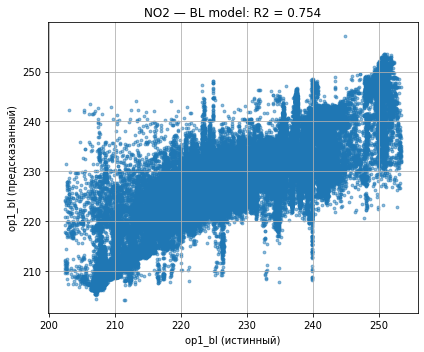

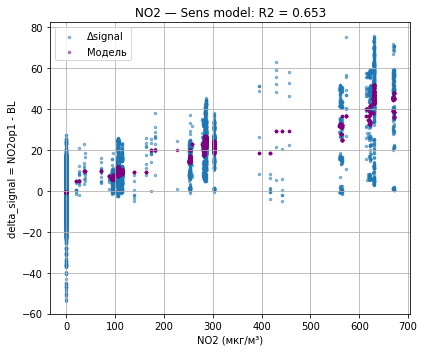

NO2 — R2 BL: 0.754, R2 sens: 0.653

====== Итоги обучения для газа: NO2 ======
Количество baseline (bl):   186217
Количество рабочих (stat):  37501
Качество baseline (BL):     R2 = 0.754
Качество sens-модели (Sens):R2 = 0.653



In [ ]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, IsolationForest
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# --- Загрузка  лабораторных данных ---
def load_lab_data(data_dir='data_example/lab_data', gases=None):
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    files = glob(os.path.join(data_dir, '*_stat.csv'))
    dfs = [pd.read_csv(file) for file in files]
    df = pd.concat(dfs, ignore_index=True).sort_values('date')

    # Добавляем градиенты по каждому газу
    for gas in gases:
        signal_col = f"{gas}op1"
        temp_col = f"{gas}t"
        if signal_col in df:
            df[f'{signal_col}_grad'] = df[signal_col].diff()
        if temp_col in df:
            df[f'{temp_col}_grad'] = df[temp_col].diff()

    df['MH_grad'] = df['MH'].diff() if 'MH' in df else np.nan
    return df

# --- Универсальная функция для расчёта baseline-маски (с очисткой по IQR/Isolation Forest) ---
def compute_baseline_mask(
    df,
    gas,
    signal_col=None,
    baseline_eps=0.01,
    use_iqr=True,
    use_isolation=False,
    contamination=None,
    verbose=False
):
    """
    Формируем маску baseline: сначала просто по концентрации, потом фильтруем выбросы по IQR и/или IsolationForest.
    """
    from sklearn.ensemble import IsolationForest

    if signal_col is None:
        signal_col = f"{gas}op1"
    temp_col = f"{gas}t"

    #  Простая маска по концентрации (== 0)
    valid_mask = df[signal_col].notna()
    bl_mask = (df[gas].fillna(0) < baseline_eps) & valid_mask

    #  Фильтруем baseline по IQR (убираем выбросы по сигналу)
    if use_iqr:
        q1 = df.loc[bl_mask, signal_col].quantile(0.25)
        q3 = df.loc[bl_mask, signal_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        iqr_mask = df[signal_col].between(lower, upper)
        bl_mask = bl_mask & iqr_mask

    #   чистим baseline с помощью Isolation Forest 
    if use_isolation:
        features = [signal_col]
        if temp_col in df: features.append(temp_col)
        if 'MH' in df: features.append('MH')
        if f"{temp_col}_grad" in df: features.append(f"{temp_col}_grad")
        if 'MH_grad' in df: features.append('MH_grad')
        iso_df = df.loc[bl_mask, features].dropna()
        if not iso_df.empty:
            # contamination  by  IQR 
            if contamination is None and use_iqr:
                extreme = (df.loc[bl_mask, signal_col] < lower) | (df.loc[bl_mask, signal_col] > upper)
                contamination_est = min(max(extreme.sum() / len(extreme), 0.001), 0.2)
            else:
                contamination_est = contamination if contamination is not None else 0.02
            if verbose:
                print(f"{gas}: estimated contamination = {contamination_est:.4f}")
            iso = IsolationForest(contamination=contamination_est, random_state=42)
            outliers = iso.fit_predict(iso_df)
            bad_idx = iso_df.index[outliers == -1]
            bl_mask.loc[bad_idx] = False

    if verbose:
        print(f"{gas}: {bl_mask.sum()} baseline (после фильтрации)")

    return bl_mask

#  маски baseline/stat для всех газов 
def add_bl_stat_masks(df, gases=None, std_thr=0.1, window=5, baseline_eps=0.001, use_isolation=True, contamination=None, verbose=True):
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    for gas in gases:
        signal_col = f"{gas}op1"

        if gas in df.columns and signal_col in df.columns:
            # Универсальная маска baseline
            df[f"{signal_col}_bl"] = compute_baseline_mask(
                df, gas,
                baseline_eps=baseline_eps,
                use_iqr=True,
                use_isolation=use_isolation,
                contamination=contamination,
                verbose=verbose
            )           

            # stat: стабильный сигнал и не baseline
            rolling_std = df[signal_col].rolling(window, center=True).std()
            df[f"{signal_col}_stat"] = (rolling_std < std_thr).fillna(False) & (~df[f"{signal_col}_bl"])

            if verbose:
                print(f"Количество точек для {gas}: {df[f'{signal_col}_bl'].sum()} baseline, {df[f'{signal_col}_stat'].sum()} stat")
        else:
            df[f"{signal_col}_bl"] = False
            df[f"{signal_col}_stat"] = False
            if verbose:
                print(f"{gas}: пропущены (нет данных)")

    return df

#  Обучение baseline и sens моделей для одного газа 
def train_for_gas(gas_name, df, bl_method='rolling', stat_method='rolling', bl_model_name='catboost', sens_model_name='catboost', draw=True):
    signal_col = f"{gas_name}op1"
    temp_col = f"{gas_name}t"
    hum_col = "MH"

    bl_col = f"{signal_col}_bl" if bl_method == 'rolling' else f"{signal_col}_bl_auto"
    stat_col = f"{signal_col}_stat" if stat_method == 'rolling' else f"{signal_col}_stat_auto"

    bl_mask = df[bl_col].fillna(False)
    stat_mask = df[stat_col].fillna(False)

    features_bl = [temp_col, hum_col, f'{temp_col}_grad', 'MH_grad']
    features_stat = features_bl + [f'{signal_col}_grad', gas_name]

    # Отбираем baseline/рабочие данные
    bl_df = df.loc[bl_mask].dropna(subset=[signal_col] + features_bl)
    stat_df = df.loc[stat_mask].dropna(subset=[signal_col] + features_stat)

    if len(bl_df) < 10 or len(stat_df) < 10:
        return {'gas': gas_name, 'error': 'Недостаточно данных для обучения'}

    X_bl = bl_df[features_bl].values
    y_bl = bl_df[signal_col].values
    X_stat = stat_df[features_stat].values
    y_signal = stat_df[signal_col].values
    X_target = stat_df[[gas_name]].values

    def get_model(name, **params):
        if name == 'linear': return LinearRegression(**params)
        if name == 'catboost': return CatBoostRegressor(verbose=0, random_seed=42, **params)
        if name == 'histgb': return HistGradientBoostingRegressor(random_state=42, **params)
        if name == 'xgb': return xgb.XGBRegressor(random_state=42, **params)
        raise ValueError(f"Неизвестная модель: {name}")

    # Baseline 
    bl_model = get_model(bl_model_name)
    bl_model.fit(X_bl, y_bl)
    y_bl_pred = bl_model.predict(X_bl)

    # Sens-модель (обучается на разнице signal - baseline)
    delta_signal = y_signal - bl_model.predict(X_stat[:, 0:4])
    sens_model = get_model(sens_model_name)
    sens_model.fit(X_target, delta_signal)
    sens_pred = sens_model.predict(X_target)

    r2_bl = r2_score(y_bl, y_bl_pred)
    r2_sens = r2_score(delta_signal, sens_pred)

    if draw:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_bl, y_bl_pred, s=8, alpha=0.5)
        plt.xlabel("op1_bl (истинный)")
        plt.ylabel("op1_bl (предсказанный)")
        plt.title(f"{gas_name} — BL model: R2 = {r2_bl:.3f}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.scatter(X_target, delta_signal, s=6, alpha=0.5, label='Δsignal')
        plt.scatter(X_target, sens_pred, color='purple', s=6, alpha=0.5, label='Модель')
        plt.xlabel(f'{gas_name} (мкг/м³)')
        plt.ylabel(f'delta_signal = {signal_col} - BL')
        plt.title(f"{gas_name} — Sens model: R2 = {r2_sens:.3f}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'gas': gas_name,
        'n_bl': len(bl_df),
        'n_stat': len(stat_df),
        'R2_bl': r2_bl,
        'R2_sens': r2_sens,
        'model_bl': bl_model,
        'model_sens': sens_model
    }

df = load_lab_data(data_dir='data_example/lab_data', gases=['NO2'])
df = add_bl_stat_masks(df, gases=['NO2'], std_thr=1.8, window=7, use_isolation=True, contamination=None, verbose=True)
result = train_for_gas('NO2', df, bl_method='rolling', stat_method='auto', bl_model_name='catboost', sens_model_name='catboost')

if 'error' in result:
    print(f"[{result['gas']}] ❌ Обучение не выполнено: {result['error']}")
else:
    print(f"\n====== Итоги обучения для газа: {result['gas']} ======")
    print(f"Количество baseline (bl):   {result['n_bl']}")
    print(f"Количество рабочих (stat):  {result['n_stat']}")
    print(f"Качество baseline (BL):     R2 = {result['R2_bl']:.3f}")
    print(f"Качество sens-модели (Sens):R2 = {result['R2_sens']:.3f}")
    if result['n_stat'] == 0:
        print(f"⚠️  Нет ни одной рабочей точки stat! Проверь разметку stat (auto/rolling), rolling-std, маску baseline.")
    print("========================================\n")
